In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib.colors import ListedColormap
import math

In [2]:
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [3]:
import warnings

In [4]:
%matplotlib inline

In [5]:
data = pd.read_csv('class_task2.txt',sep=';')

In [6]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TB        521 non-null    int64  
 1   cost      521 non-null    float64
 2   earnings  521 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 12.3 KB


### 1. Для начала просто посмотрим на наши данные и попытаемся их визуализировать, видов тербанков у нас 50 - это довольно много, поэтому вряд ли каждый тербанк будет рассматриваться отдельно.

Text(0, 0.5, 'Earnings')

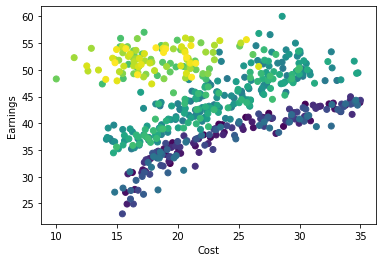

In [7]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 50))
newcmp = ListedColormap(newcolors)
plt.scatter(list(map(lambda x: x, data['cost'])), list(map(lambda y: y, data['earnings'])), c=data['TB'].tolist(), cmap=newcmp)
plt.xlabel('Cost')
plt.ylabel('Earnings')

### Как видно, между расходами и доходами во многих видах тербанков существует взимосвязь, возможно, где-то даже близкая к линейной.

### 2. Теперь посмотрим на описательную статистику наших данных, чтобы понять, с чем имеем дело.

In [8]:
data[['cost','earnings']].describe()

,cost,earnings
count,521.000000,521.000000
mean,22.645116,43.828052
std,5.440514,7.002857
min,10.000000,23.058300
25%,18.305000,38.905500
50%,21.714400,43.619500
75%,27.009200,49.646000
max,35.000000,60.000000


#### Как видно, доходы у нас в среднем в два раза выше расходов. 50% наблюдений имеют расходы менее 21, также 50% наблюдений имеют доходы выше 43. Как видно, минимальное значение расходов равно 10, а максимальные доходы равны 60.

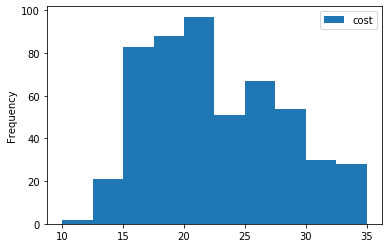

In [9]:
data[['cost']].plot.hist()

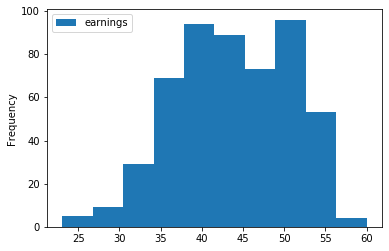

In [10]:
data[['earnings']].plot.hist()

#### По гистограммам плотностей распределения заметно, что расходы в банке более смещены влево, а доходы вправо. Это неудивительно, так как логична стратегия максимизации доходов и уменьшения расходов. Хотя распределение расходов слегка напоминает бимодальное, так как в промежутке от 15 до 20 и от 25 до 30 сконцентрировано прилично наблюдений.

#### Посмотрим все же на зависимость цены и расходов в отдельных тербанках. Как видно, существуют тербанки, где наблюдений достаточно и прослеживается четкая зависимость между признаками. Где-то наблюдений совсем мало, такие тербанки стоит убрать из рассмотрения. Где-то зависимость более сложная.

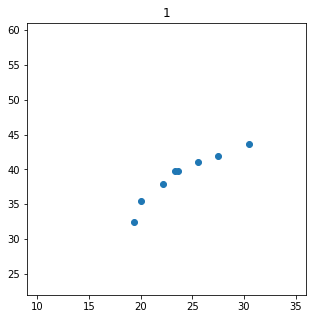

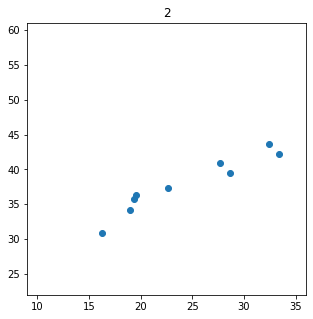

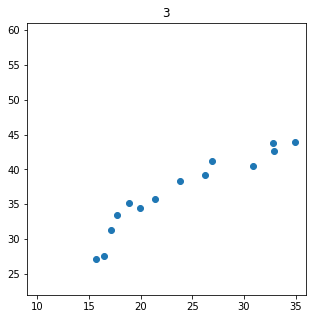

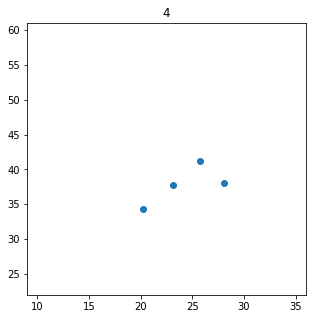

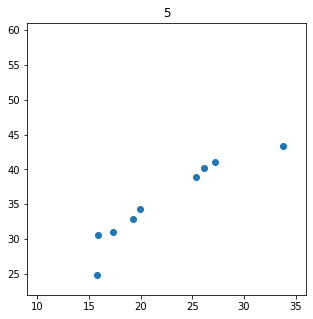

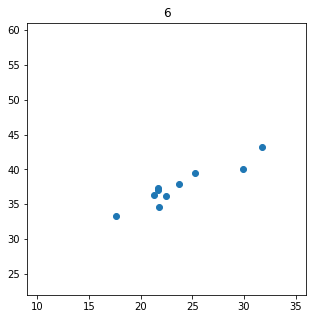

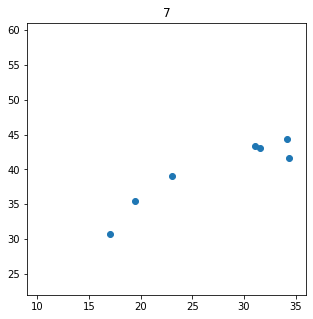

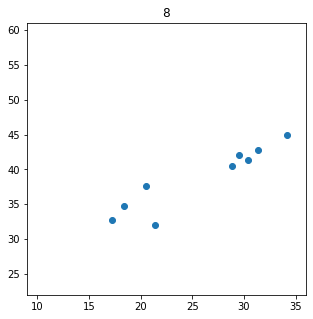

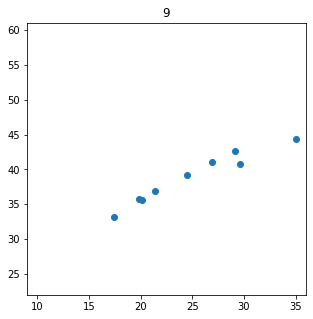

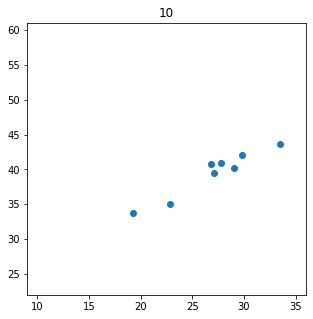

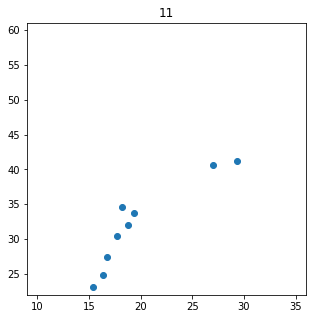

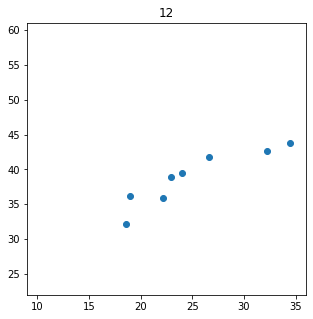

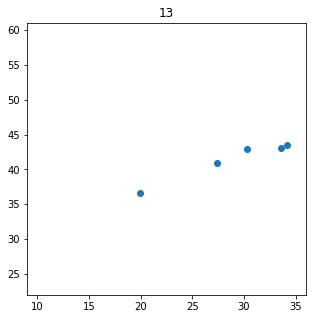

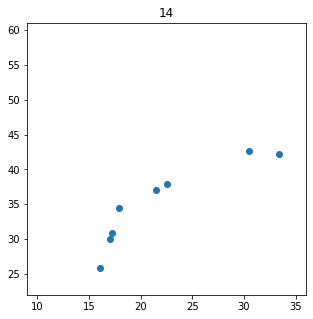

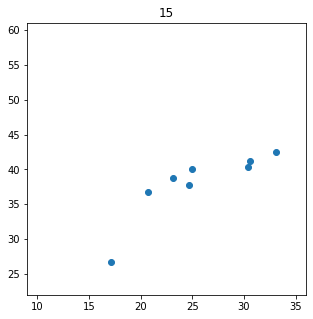

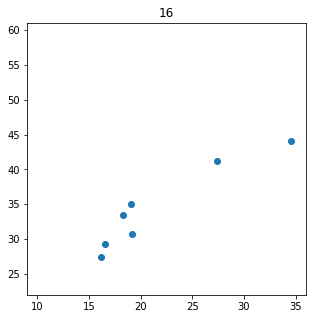

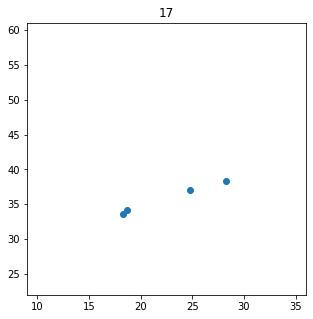

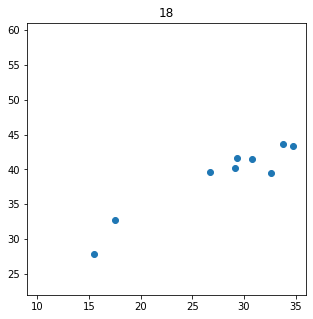

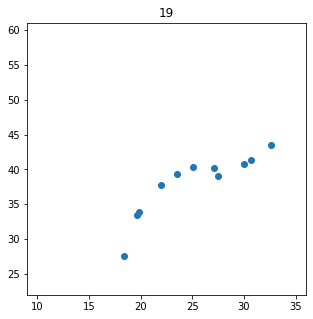

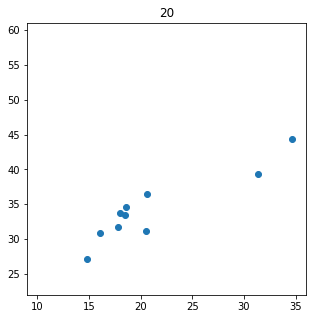

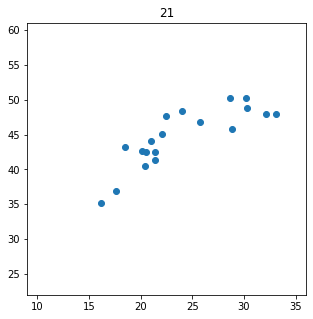

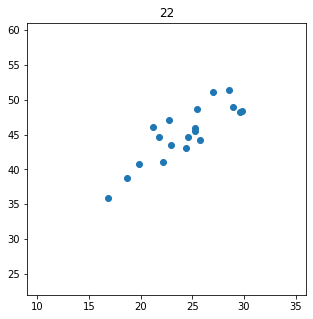

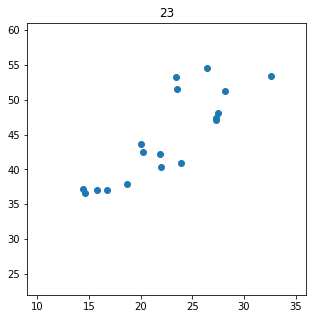

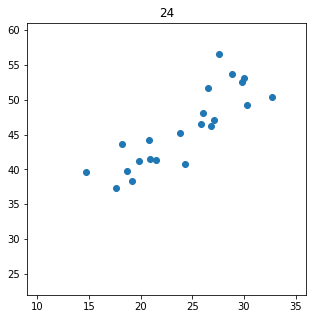

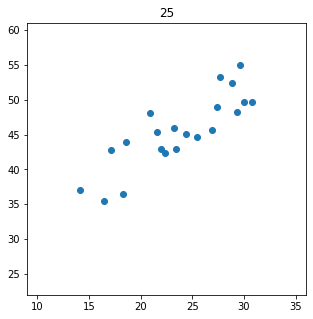

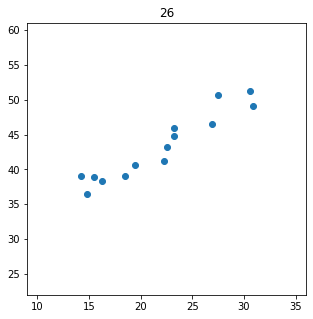

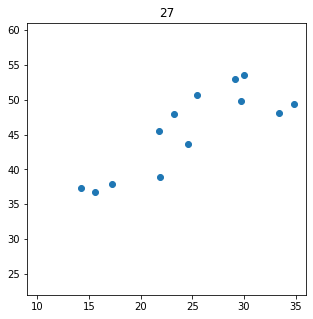

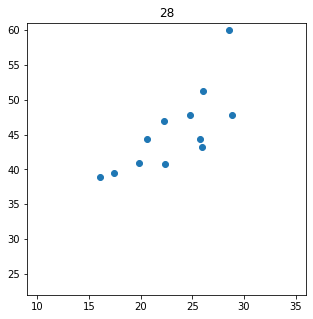

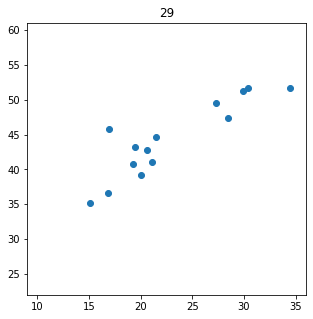

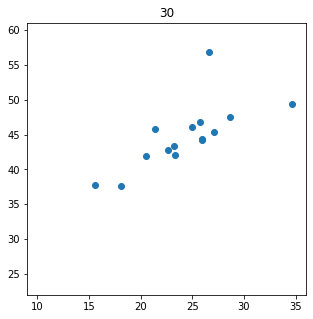

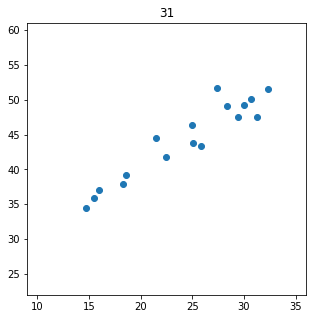

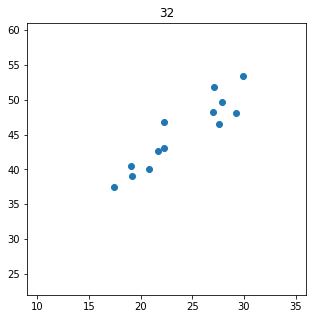

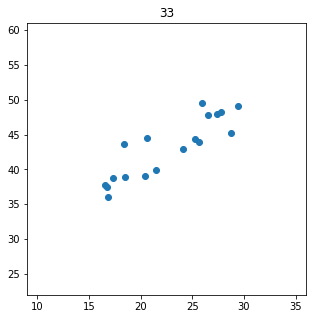

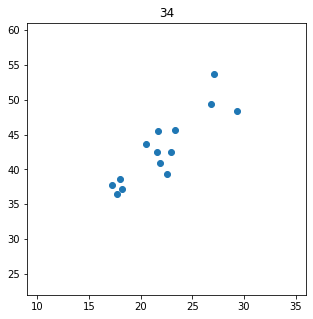

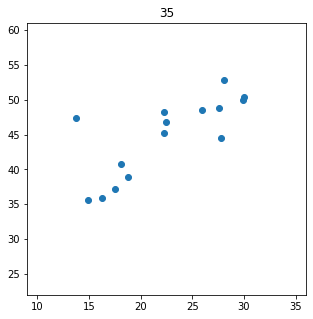

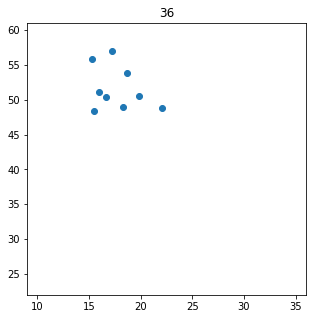

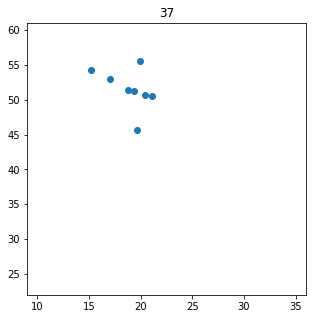

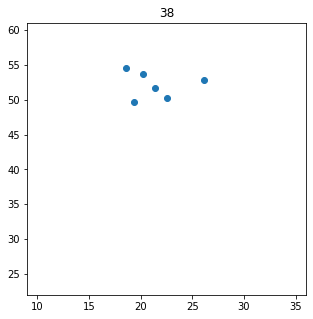

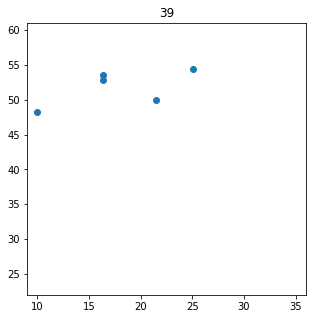

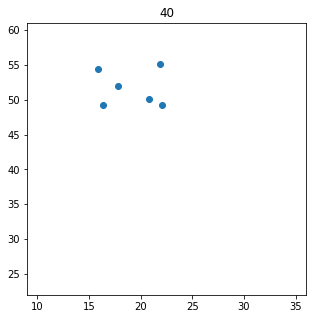

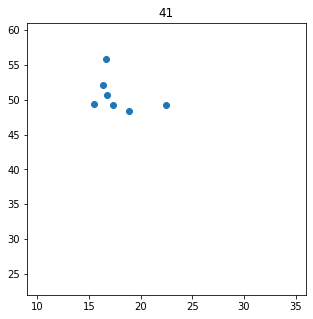

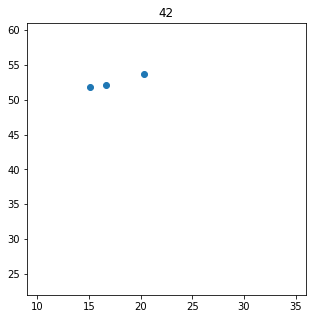

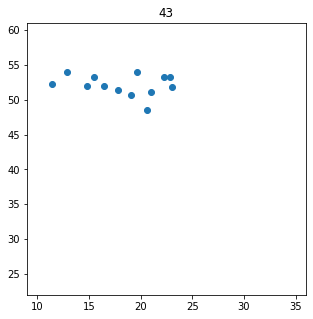

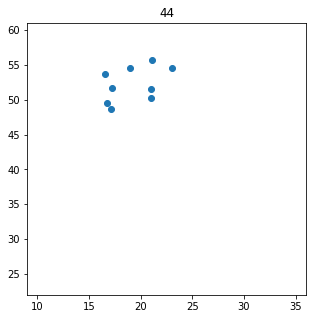

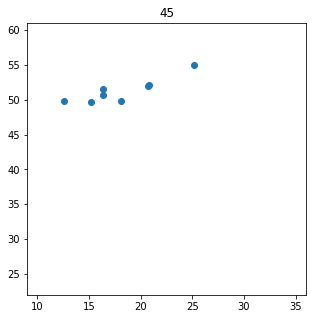

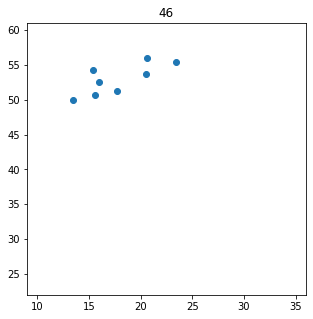

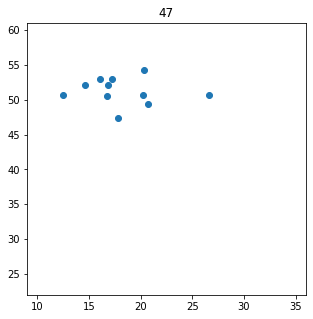

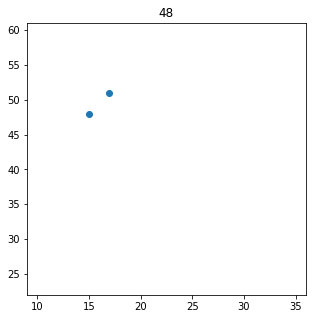

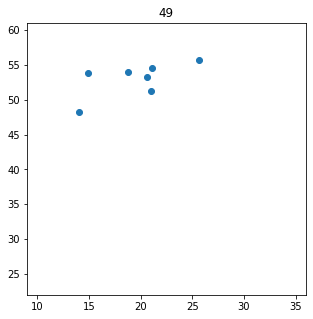

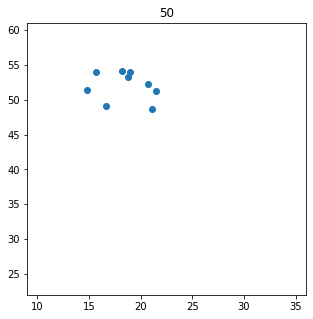

In [11]:
warnings.filterwarnings('ignore')
for i in range(0,50):
    plt.figure(figsize=(5, 5))
    #plt.subplot(10,5,i+1)
    data_tb = data[data['TB']==i+1]
    plt.scatter(data_tb['cost'], data_tb['earnings'])
    plt.xlim(9, 36)
    plt.ylim(22, 61)
    plt.title(i+1)

#### Как видно выше, в некоторых тербанках у нас слишком мало наблюдений, мы их рассматривать и не будем.

In [12]:
data['TB'].value_counts()

24    22
25    21
21    19
22    19
33    18
23    18
31    17
35    15
30    15
34    14
29    14
26    14
3     14
27    13
43    13
32    13
28    12
19    11
47    11
20    10
6     10
18     9
11     9
9      9
8      9
5      9
2      9
50     9
44     9
36     9
1      8
10     8
37     8
46     8
45     8
15     8
14     8
12     8
7      7
41     7
49     7
16     7
38     6
40     6
13     5
39     5
17     4
4      4
42     3
48     2
Name: TB, dtype: int64

#### Видим, что в тербанках с 20-ми номерами больше наблюдений. 42, 48, 4, 17 тербанки точно убираем из рассмотрения. В 13, 39 тербанках, конечно, прослеживается то, что увеличение расходов совпадает с увеличением доходов, но наблюдений все же мало. 38, 40 убираем тоже, так как данные там не имеют даже примерно выраженной зависимости.

In [13]:
for i in [48, 4, 42, 17, 13, 39, 38, 40]:
    data = data.drop(data[data['TB'] == i].index) 

### Посмотрим на корреляцию между расходами и доходами в датасете.

In [14]:
data[['cost','earnings']].corr(method='pearson')

,cost,earnings
cost,1.000000,0.275931
earnings,0.275931,1.000000


#### Как видно, она не столь высокая между расходами и доходами по всему датасету, поэтому тем более надо смотреть отдельно на тербанки.

In [15]:
coeffs_90higher, coeffs_80_90, coeffs_80lower, coeffs_negative = [], [], [], []
for i in range(0,50):
    corr_coef = data[data['TB']==i+1][['cost', 'earnings']].corr().iloc[0,1]
    if corr_coef>=0.9:
        coeffs_90higher.append(i+1)
    elif corr_coef>=0.8:
        coeffs_80_90.append(i+1)
    elif corr_coef<0:
        coeffs_negative.append(i+1)
    elif math.isnan(corr_coef) == False:
        coeffs_80lower.append(i+1)  
    print('Номер тербанка: ',i+1, "\n", corr_coef)

Номер тербанка:  1 
 0.9380155410761349
Номер тербанка:  2 
 0.9540667029931196
Номер тербанка:  3 
 0.943073139930362
Номер тербанка:  4 
 nan
Номер тербанка:  5 
 0.9413971336327552
Номер тербанка:  6 
 0.9376230195782551
Номер тербанка:  7 
 0.9346234343996402
Номер тербанка:  8 
 0.9308100092646509
Номер тербанка:  9 
 0.9748225203517803
Номер тербанка:  10 
 0.960492588779982
Номер тербанка:  11 
 0.9101356745838843
Номер тербанка:  12 
 0.9096680092723325
Номер тербанка:  13 
 nan
Номер тербанка:  14 
 0.9066385219990254
Номер тербанка:  15 
 0.8527833138516364
Номер тербанка:  16 
 0.9428178957185422
Номер тербанка:  17 
 nan
Номер тербанка:  18 
 0.9537122679879861
Номер тербанка:  19 
 0.8804524877852891
Номер тербанка:  20 
 0.9166655300350862
Номер тербанка:  21 
 0.8293273451341187
Номер тербанка:  22 
 0.850319962625938
Номер тербанка:  23 
 0.8402383563873164
Номер тербанка:  24 
 0.848998007310296
Номер тербанка:  25 
 0.8451117031561941
Номер тербанка:  26 
 0.952065735

#### Заеметим, что в категорию со значением коэффициента корреляции между доходами и расходами выше 0.9 попали тербанки с номерами первой десятки, в основном у них от 9 до 14 представителей в выборке. А вот в категорию со значениями корреляции признаков от 0.8 до 0.9 попали в основном тербанки с наибольшим количеством представителей в выборке. Это логично, ведь чем больше данных, тем чаще всего больше информации они нам дают, данные могут быть более разнородные. В категорию с отрицательными коэффициентами корреляции попали 6ть банков, однако корреляция по модулю у них небольшая, самая высокая по модулю в этой группе она у 37 тербанка и равна 0.4, но это тоже не столь высокое значение.

In [16]:
print(coeffs_90higher)
print(coeffs_80_90)
print(coeffs_80lower)
print(coeffs_negative)

[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 26, 31, 32]
[15, 19, 21, 22, 23, 24, 25, 27, 29, 33, 34, 45]
[28, 30, 35, 44, 46, 49]
[36, 37, 41, 43, 47, 50]


### 3. Кластеризация тербанков по средним расходам и доходам

#### Можно попробовать не зацикливаться именно на номере банка, а попытаться кластеризовать их в зависимости только от двух признаков. Найдем для каждого тербанка среднее значение доходов и рассходов по всем его представлениям в наших данных. Далее попробуем разделить их на группы и посмотреть, как эти группы связаны с корреляцией между доходами и расходами.

In [17]:
TB_means = data.groupby('TB').mean()

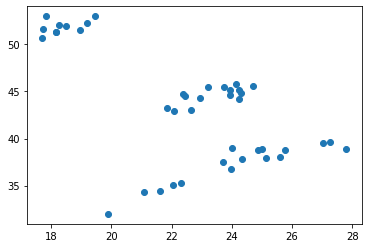

In [18]:
plt.scatter(TB_means['cost'], TB_means['earnings'])

In [19]:
clf = KMeans(n_clusters=3, random_state=0)
clf.fit(TB_means)
clf.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
clf.cluster_centers_

array([[18.39569567, 51.86427844],
       [23.39045551, 44.60975776],
       [24.19820306, 37.21215067]])

Text(0, 0.5, 'Earnings')

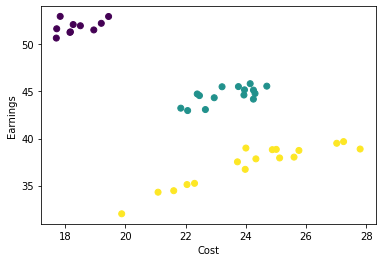

In [21]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 3))
newcmp = ListedColormap(newcolors)
plt.scatter(list(map(lambda x: x, TB_means['cost'])), list(map(lambda y: y, TB_means['earnings'])), c=clf.labels_, cmap=newcmp)
plt.xlabel('Cost')
plt.ylabel('Earnings')

#### Мы видим, что наблюдения в принципе кластеризовались правильно. 

In [22]:
TB_means = TB_means.reset_index()

In [23]:
TB_means_clustered = pd.concat([TB_means, pd.DataFrame(clf.labels_)], axis=1, sort=False)

In [24]:
TB_means_clustered

,TB,cost,earnings,0
0,1,24.001250,38.987412,2
1,2,24.333589,37.840033,2
2,3,23.978450,36.726921,2
3,5,22.295756,35.240611,2
4,6,23.720420,37.524260,2
5,7,27.244786,39.671871,2
6,8,25.761822,38.733967,2
7,9,24.878067,38.815844,2
8,10,27.017562,39.495225,2
9,11,19.876844,32.008600,2


#### (0 кластер) Для тербанков с номерами 36-37, 41, 43-47, 49-50 - центры кластера: расходы = 18.39569567, доходы = 51.86427844.
#### (1 кластер) Для тербанков с номерами 21-35 - центры кластера: расходы = 23.39045551, доходы = 44.60975776.
#### (2 кластер) Для тербанков с номерами 1-3,  5-12, 14-16, 18-20 - центры кластера: расходы = 24.19820306, доходы = 37.21215067.

### Заметно, что в тербанках нулевого кластера (самого немногочисленного) самая большая разница в среднем между доходами и расходами. Доходы довольно высокие, а расходы самые низкие. В тербанках первого кластера доходы и расходы средние. А вот в тербанках второго кластера (который преобладает в выборке) самые высокие расходы и самые низкие доходы. Они, скорее всего, функционируют не столь эффективно, как в первом кластере.

#### Если сопоставить эти результаты с коэффициентами корреляции между доходами и расходами представителей отдельных тербанков кластера, то можно сказать, что во втором кластере самая высокая линейная положительная, очень сильная зависимость между доходами и расходами для отдельных тербанков. В первом кластере зависимость между доходами и расходами тоже прямая, связь довольна сильная, но поменьше, чем во втором кластере. А в нулевом кластере находятся наблюдения или с обратной зависимостью, или же с прямой, но слабоватой между доходами и расходами (мы видим, что там довольно сильно разбросаны данные).

#### Чем меньше разница между доходами и расходами в кластере, тем выше зависимость между двумя этими показателями у тербанков кластера.

### 4. Найдем коэффициенты корреляции между доходами и расходами, только теперь не для отдельных тербанков, а для трех класторов и входящих в них наблюдений соответственно.

In [25]:
data_2cluster = data[data['TB']<=20]
data_1cluster = data[(data['TB']>20) & (data['TB']<=35)]
data_0cluster = data[data['TB']>=36]

In [26]:
print('Корреляция Пирсона между расходами и доходами для второго кластера:')
data_2cluster[['cost', 'earnings']].corr().iloc[0,1]

Корреляция Пирсона между расходами и доходами для второго кластера:


0.9135856406728702

In [27]:
print('Корреляция Пирсона между расходами и доходами для первого кластера:')
data_1cluster[['cost', 'earnings']].corr().iloc[0,1]

Корреляция Пирсона между расходами и доходами для первого кластера:


0.8383439315381627

In [28]:
print('Корреляция Пирсона между расходами и доходами для нулевого кластера:')
data_0cluster[['cost', 'earnings']].corr().iloc[0,1]

Корреляция Пирсона между расходами и доходами для нулевого кластера:


0.12842985998899561

#### Видно, что для второго кластера связь очень сильная, прямая. Для первого кластера связь просто сильная и прямая. В нулевом кластере связь не столь однозначна, так как там находятся тербанки и с низкой положительной корреляцией расходов и доходов, и с отрицательной.

### 5. Раз видно, что для второго и первого кластера связь между доходами и расходами есть, она даже напоминает линейную, то попробуем построить линейный тренд, показывающий зависимость доходов от расходов для двух этих кластеров. На всякий случай, желтым цветом будет показан и третий кластер, но для него, конечно, адекватную линейную модель построить нельзя.

In [29]:
def f(x, A, B):
    return x*A + B

In [30]:
popt, pocov = curve_fit(f,data_2cluster['cost'], data_2cluster['earnings'])

In [31]:
popt1, pocov1 = curve_fit(f,data_1cluster['cost'], data_1cluster['earnings'])

In [32]:
popt0, pocov0 = curve_fit(f,data_0cluster['cost'], data_0cluster['earnings'])

Text(0, 0.5, 'Earnings')

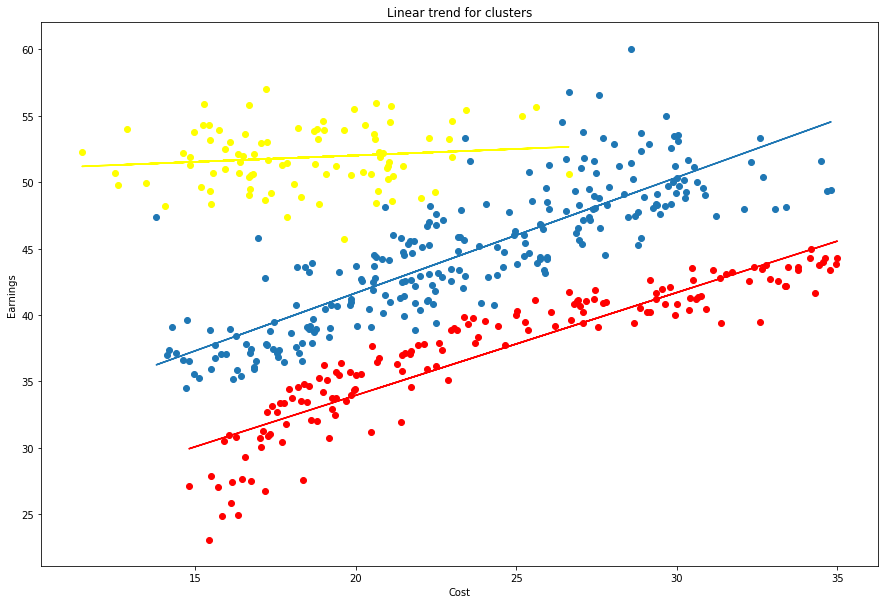

In [33]:
plt.figure(figsize=(15,10))
plt.plot(data_2cluster['cost'], f(data_2cluster['cost'], *popt), color='red')
plt.scatter(data_2cluster['cost'], data_2cluster['earnings'], color='red')

plt.plot(data_1cluster['cost'], f(data_1cluster['cost'], *popt1))
plt.scatter(data_1cluster['cost'], data_1cluster['earnings'])

plt.plot(data_0cluster['cost'], f(data_0cluster['cost'], *popt0), color='yellow')
plt.scatter(data_0cluster['cost'], data_0cluster['earnings'], color='yellow')

plt.title('Linear trend for clusters')
plt.xlabel('Cost')
plt.ylabel('Earnings')

#### Таким образом, для первого и второго кластера линейный тренд выглядит так:

In [34]:
r2_sc_2cluster = r2_score(data_2cluster['earnings'], data_2cluster['cost']*popt[0]+popt[1])
print('Для второго кластера: ', 'Earnings = costs * ', popt[0], ' + ', popt[1])
print('R2: ', r2_sc_2cluster)

Для второго кластера:  Earnings = costs *  0.774450764947744  +  18.45605518325915
R2:  0.8346387228436585


In [35]:
r2_sc_1cluster = r2_score(data_1cluster['earnings'], data_1cluster['cost']*popt1[0]+popt1[1])
print('Для первого кластера: ', 'Earnings = costs * ', popt1[0], ' + ', popt1[1])
print('R2: ', r2_sc_1cluster)

Для первого кластера:  Earnings = costs *  0.8709200199812217  +  24.236110037171038
R2:  0.702820547546863


#### Если для второго кластера R2 хороший, то для первого он не столь высок, хотя визуально видно, что в общем и целом модель неплохо улавливает разбросы в данных.

#### При увеличении расходов на единицу, в первом кластере доходы увеличиваются  на 0.87, а во втором на 0.77.

### 5. Итог

#### Таким образом, в ходе всего вышеприведенного анализа делались выводы о взаимосвязи доходов и расходов в тербанках. Обощенный итог в том, что в общем и целом по всем тербанкам доходы выше расходов приблизительно в 2 раза. Еще при первом взгляде на данные стало понятно, что в большинстве своем связь между доходами и расходами, безусловно, имеется.
#### Ясно, что для детального анализа взаимосвязи показателей данные необходимо делить. Еще на этапе рассмотрения отдельных тербанков стало понятно, что есть группа тербанков с очень сильной линейной связью доходов и расходов, затем есть кластер с тоже высоким показателем прямой зависимости между доходами и расходами. Также есть третья группа с тербанками, где связь либо слишком маленькая и положительная, либо отрицательная. Связь "чем выше расходы, тем ниже доходы" наблюдается в тербанках с номерами 36, 37, 41, 43, 47, 50. На них нужно обязательно обратить внимание и рассматривать их деятельность более подробно при дополнительной информации.
#### В ходе кластеризации был выявлен самый многочисленный второй кластер, где разница между средними расходами и доходами не столь велика, но тем не менее связь очень сильная и прямая. Для него был построен линейный тренд, который как раз показал, что при увеличении расходов на единицу доходы вырастут на 0.77. Также был найден второй кластер с более низким коэффициентом корреляции расходов и доходов, но тем не менее, показывающим, что связь тоже прямая и сильная.  И также существовал третий кластер с разрозненными данными. Получилось, что чем меньше разница между доходами и расходами в кластере, тем выше зависимость между двумя этими показателями у тербанков кластера. Более подробно про то, тербанки с какими номерами входят в кластеры, про коэффициент корреляции, про численные показатели можно прочитать во 2, 3, 4 пунктах. 
#### В ходе самого анализа были сделаны многие выводы, поэтому в ходе его прочтения становятся ясны выводы о связи доходов и расходов.